In [1]:
import MDAnalysis as mda 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import clustering.cluster as psw_cluster
import ICSI.icsi as icsi
import IPI.ipi as ipi

/Users/rmz/opt/anaconda3/envs/pol/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topology_ = '../../../for_hrach/tx114/production.tpr'

trajectory_ = '../../../for_hrach/tx114/production.trr'

u=mda.Universe(topology_,trajectory_)



In [25]:
u.trajectory[10]
water_resids = np.unique(u.select_atoms('name OW and around 3.2 (resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A)').resids)
water_sel  = u.select_atoms('name OW and resid '+str(' '.join([str(i) for i in water_resids])))


In [26]:
water_sel

<AtomGroup with 29 atoms>

# Example intrinsic tracking calculation - water around micelle core

In [27]:


n_rand_points=50000
start,stop,skip=10,30,1

# micelle_shell = 'resname TX4 and not name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011'

micelle_core = 'resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011'
micelle_shell = 'name OW and resid '+str(' '.join([str(i) for i in water_resids]))

### create lists to save data
intrinsic_positions_solute = [] 


for ts in u.trajectory[start:stop:skip]:
    
    #find the largest cluster (this is the micelle)
    
    largest_cluster_resids=psw_cluster.find_largest_cluster(u,
                                   frame=ts.frame,
                                   selection='name C*',
                                   cutoff_distance=10,
                                   define_clustering_atoms=False)()

    #unwrap the micelle coordinates
    
    cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions =psw_cluster.make_cluster_whole(u,
                                    frame = ts.frame,
                                    cluster_resids  = largest_cluster_resids,
                                    core_selection  = micelle_core,
                                    shell_selection = micelle_shell,
                                    solvent=True)()
    
    #calculate the intrinsic positions of the micelle shell using ICSI
    
    intrinsic_r, spherical_r, icsi_vals = icsi.icsi(u, 
                                                        
                                    cluster_resids=largest_cluster_resids,
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions=shell_sel_atoms_positions,
                                    frame=ts.frame,
                                    no_bins=31,
                                    no_random_points=n_rand_points,
                                    normalisation_run=False)()

    #bin and save the intrinsic positions 
    
    intrinsic_positions_solute.append(intrinsic_r)
        

    print(ts)

#calculate the time of each frame used above for plotting    
times = [ts.time/1000 for ts in u.trajectory[start:stop:skip]]


< Timestep 10 with unit cell dimensions [118.81943 118.81943 118.81943  90.       90.       90.     ] >
< Timestep 11 with unit cell dimensions [119.01562 119.01562 119.01562  90.       90.       90.     ] >
< Timestep 12 with unit cell dimensions [118.88957 118.88957 118.88957  90.       90.       90.     ] >
< Timestep 13 with unit cell dimensions [118.9724 118.9724 118.9724  90.      90.      90.    ] >
< Timestep 14 with unit cell dimensions [118.872215 118.872215 118.872215  90.        90.        90.      ] >
< Timestep 15 with unit cell dimensions [118.800064 118.800064 118.800064  90.        90.        90.      ] >
< Timestep 16 with unit cell dimensions [118.93833 118.93833 118.93833  90.       90.       90.     ] >
< Timestep 17 with unit cell dimensions [118.86817 118.86817 118.86817  90.       90.       90.     ] >
< Timestep 18 with unit cell dimensions [118.96216 118.96216 118.96216  90.       90.       90.     ] >
< Timestep 19 with unit cell dimensions [118.94328 118.943

# Plot calculated tracking positions

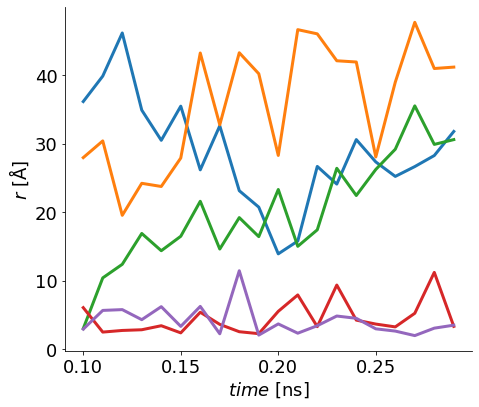

In [34]:

plt.rcParams.update({'font.size': 18})


fig=plt.figure(figsize=(7,6))
ax = plt.subplot(111)
for i in range(5):
    
    plt.plot(times,[k[i] for k in intrinsic_positions_solute],lw=3)

plt.xlabel(r'$time \ [{\mathrm{ns}}]$')
plt.ylabel(r'$r \ [{\mathrm{\AA}}]$')

# plt.xlim(-20,30)
# plt.ylim(0,0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig('intrinsic_density_tx114.pdf')
plt.show()

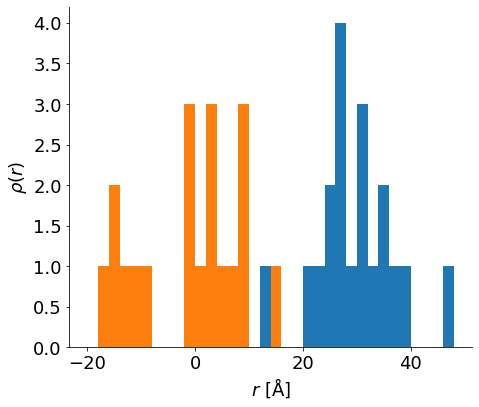

In [63]:
plt.rcParams.update({'font.size': 18})


fig=plt.figure(figsize=(7,6))
ax = plt.subplot(111)
for i in range(0,21,20):
    
    plt.hist([k[i] for k in intrinsic_positions_solute],bins=np.arange(-20,50,2))

plt.xlabel(r'$r \ [{\mathrm{\AA}}]$')
plt.ylabel(r'$\rho(r)$')

# plt.xlim(-20,30)
# plt.ylim(0,0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig('intrinsic_density_tx114.pdf')
plt.show()

In [55]:
micelle_shell = 'name OW and resid '+str(' '.join([str(i) for i in water_resids]))

### create lists to save data
selection_hydration = [] 


for ts in u.trajectory[start:stop:skip]:
    
    tmp=[]
    
    for atom in water_resids:
        tmp.append(len(u.select_atoms('name OW and around 4.5 name OW and resid '+str(atom))))

    selection_hydration.append(tmp)
    

In [73]:
intrinsic_hydration = stats.binned_statistic(sum(intrinsic_positions_solute,[]),sum(selection_hydration,[]),
                                             bins=np.arange(-30,30,5),
                                             statistic=np.mean)

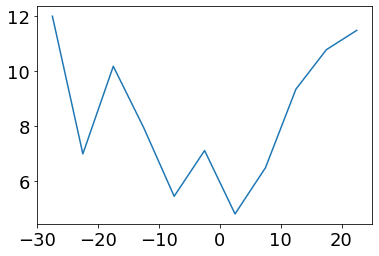

In [75]:
plt.plot(np.arange(-27.5,25,5),  intrinsic_hydration.statistic)
plt.show()

In [58]:
[ intrinsic_hydration.bin_edges]

array([-30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20.,
       -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.])